In [1]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import torch.optim as optim

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms, Resize, ToTensor, Normalize
from PIL import Image
from torch.utils.data import DataLoader

In [19]:
img_path_train="dataset/images/"
lbl_path_train="dataset/labels/"
img_path_val = "images_val/"
lbl_path_val = "labels_val/"
sample_list_train = os.listdir(img_path_train)
sample_list_val = os.listdir(img_path_val)
device = torch.device("cuda:0")

In [20]:
class CustomDst(Dataset):
    def __init__(self, list_of_img, image_path, labels_path, transform=None):
        self.image_path = image_path
        self.labels_path = labels_path
        self.transform = transform
        self.list_of_img = list_of_img

    def __len__(self):
        return len(self.list_of_img)
    
    def __getitem__(self,idx):
        img=Image.open(self.image_path+self.list_of_img[idx])
        label=Image.open(self.labels_path+self.list_of_img[idx])
        
        img=Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))(ToTensor()(img))
        label=ToTensor()(label)
        
        
        if self.transform:
            seed = np.random.randint(0, 2**32)
            np.random.seed(seed)
            torch.manual_seed(seed)
            img = self.transform(img)
            np.random.seed(seed)
            torch.manual_seed(seed)
            
            label = self.transform(label)
            label = label[1]
            label = torch.where(label > 0,1.0,0.0).unsqueeze(0)
            return img, label
        else:
            return img, label
    

In [21]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.3)
])

In [22]:
dataset_train=CustomDst(sample_list_train,img_path_train,lbl_path_train,transform=transform)
dataset_val=CustomDst(sample_list_val,img_path_val,lbl_path_val,Resize((512,512)))

train_loader=DataLoader(dataset_train,batch_size=4,shuffle=True)
test_loader=DataLoader(dataset_val,batch_size=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


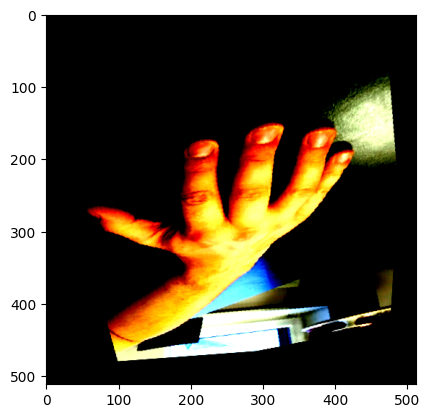

torch.Size([1, 512, 512])


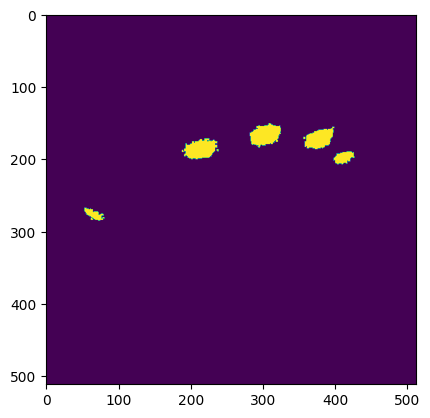

In [23]:
for i in dataset_train:
    plt.imshow(i[0].permute(1,2,0))
    plt.show()
    print(i[1].shape)
    plt.imshow(i[1][0])
    plt.show()
    break

In [57]:
model = smp.Unet(encoder_name="resnet152", in_channels=3, classes=1, encoder_weights="imagenet")
device = torch.device("cuda:3")
model=model.to(device)
optimizer=Adam(model.parameters(),lr=1e-5)
loss_fn=nn.BCEWithLogitsLoss()
# model

In [58]:
def calculate_iou(gt, pred, confidence=0.5):
    pred_thresholded = pred > confidence

    intersection = np.logical_and(gt, pred_thresholded)
    union = np.logical_or(gt, pred_thresholded)
    iou = np.sum(intersection) / (np.sum(union) + 1e-5)
    return iou

In [59]:
best_mIOU = 0
val_loss = []
train_loss = []
for epoch in range(100):
    running_loss = 0.0
    items = 0.0
    ious_train = []
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
        items += targets.size(0)
        
        for i in range(len(outputs)):
            y_pred = (outputs[i].cpu().detach().numpy() >= 0.5).astype(int)
            ious_train.append(calculate_iou(targets[i].cpu().detach().numpy(), y_pred))
            
    train_loss.append(((running_loss/items).cpu().detach().numpy()))
    print(f"Epoch {epoch}: train_running_loss {running_loss/items}")
    print(f"         train_mIOU {np.mean(ious_train)}")
    
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        items = 0.0
        ious_val = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            running_loss += loss
            items += targets.size(0)
            
            for i in range(len(outputs)):
                y_pred = (outputs[i].cpu().detach().numpy() >= 0.5).astype(int)
                ious_val.append(calculate_iou(targets[i].cpu().detach().numpy(), y_pred))
        val_loss.append(((running_loss/items).cpu().detach().numpy()))
        print(f"         val_running_loss {running_loss/items}")
        print(f"         val_mIOU {np.mean(ious_val)}")
        print()
        
        if np.mean(ious_val) > best_mIOU:
            best_mIOU = np.mean(ious_val)
            torch.save(model.state_dict(), 'best_model.pt')


Epoch 0: train_running_loss 0.12066604942083359
         train_mIOU 0.03043762658127498
         val_running_loss 0.12325621396303177
         val_mIOU 0.0010797555477113064

Epoch 1: train_running_loss 0.11714061349630356
         train_mIOU 0.057515279546670024
         val_running_loss 0.12254160642623901
         val_mIOU 0.07234262062918084

Epoch 2: train_running_loss 0.1140165701508522
         train_mIOU 0.09528050096515578
         val_running_loss 0.12166855484247208
         val_mIOU 0.16462060744152318

Epoch 3: train_running_loss 0.1119629293680191
         train_mIOU 0.10853677762695786
         val_running_loss 0.11677517741918564
         val_mIOU 0.20866060131380143

Epoch 4: train_running_loss 0.10850170999765396
         train_mIOU 0.14556411945539033
         val_running_loss 0.11300617456436157
         val_mIOU 0.2971544607555554

Epoch 5: train_running_loss 0.10503598302602768
         train_mIOU 0.1916368740300019
         val_running_loss 0.10791400074958801
  

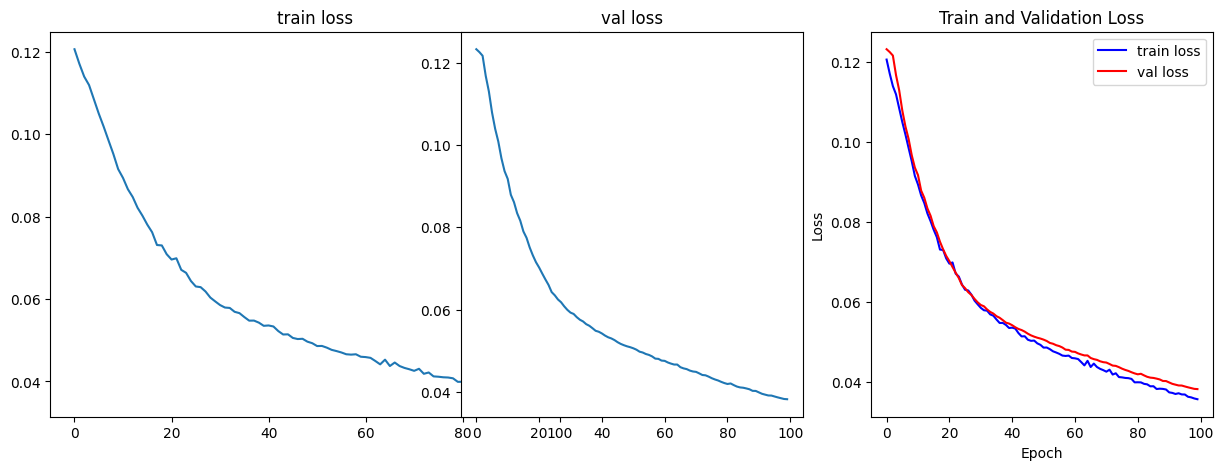

In [60]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('train loss')
plt.plot(train_loss)

plt.subplot(1, 3, 2)
plt.title('val loss')
plt.plot(val_loss)

plt.subplot(1, 3, 3)
plt.plot(train_loss, label='train loss', color='blue')
plt.plot(val_loss, label='val loss', color='red')

plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.tight_layout()
# plt.show()
# print(train_loss)
# print(train_loss[0])
# # print(train_loss[0][0])
# for i in range(len(train_loss)):
#     print(train_loss[i])
# print(train_loss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


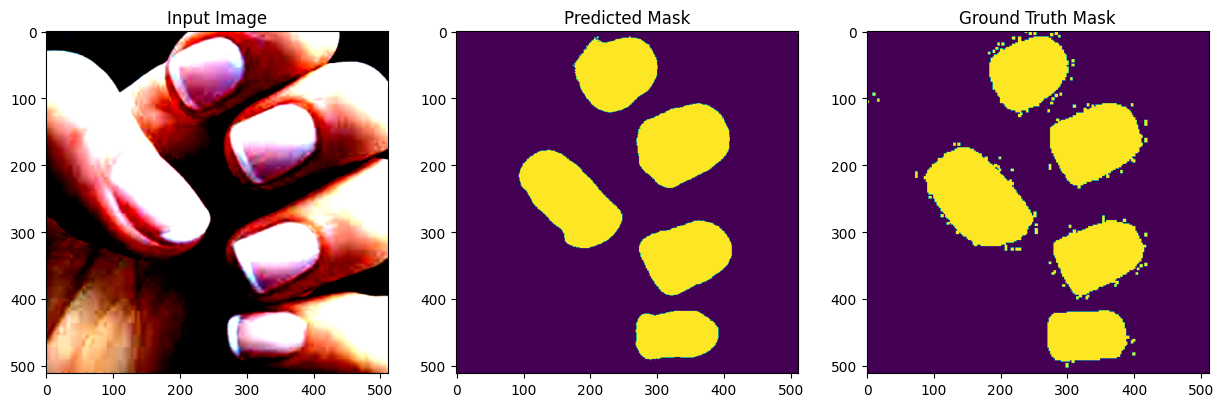

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


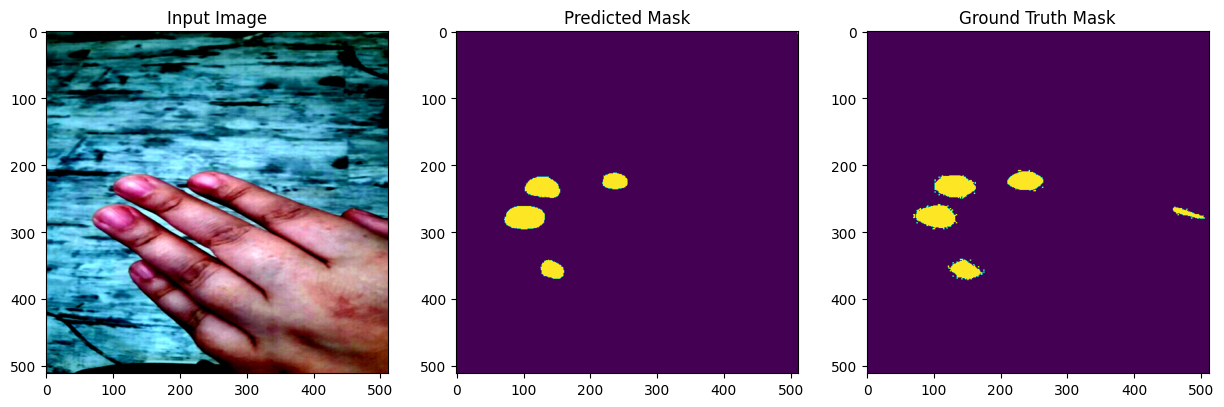

In [61]:
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        n = 0
        X, y = X[n].to(device), y[n].to(device)

        predMask = model(X.unsqueeze(0))
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        predMask = (predMask > 0.5) * 255

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(X.permute(1, 2, 0).to('cpu'))
        axs[0].set_title('Input Image')
        axs[1].imshow(predMask[0][0])
        axs[1].set_title('Predicted Mask')
        axs[2].imshow(y[0].to('cpu'))
        axs[2].set_title('Ground Truth Mask')

        plt.show()
